In [155]:

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.login(user='mtauraso', password='o>th2vNGf#p@y6?#')

def query_gaia():

    fields_of_interest = f"""--
    source_id,
    ra, dec,
    pmra,
    pmra_error,
    pmdec,
    pmdec_error,
    parallax,
    parallax_error,
    parallax_over_error,
    phot_g_mean_mag,
    bp_rp
    """

    query = f"""
    SELECT 
    --TOP 100000
    {fields_of_interest}
    FROM {Gaia.MAIN_GAIA_TABLE}
    --JOIN external.gaiaedr3_distance as d USING (source_id) -- For Bailer-Jones Distances
    --JOIN gaiadr3.astrophysical_parameters as ap USING (source_id) -- For Extinction in all bands
    WHERE 
        (astrometric_params_solved = 31 OR astrometric_params_solved = 63) AND
        phot_g_mean_mag is not NULL AND
        --random_index BETWEEN 0 AND 10000000
        random_index BETWEEN 0 AND 20000000 AND parallax_over_error < 10 AND parallax_over_error > -10
    """
    job = Gaia.launch_job_async(query, verbose = True)
    r = job.get_results()
    r.info()
    return r

data = query_gaia()
    

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Launched query: '
    SELECT 
    --TOP 100000
    --
    source_id,
    ra, dec,
    pmra,
    pmra_error,
    pmdec,
    pmdec_error,
    parallax,
    parallax_error,
    parallax_over_error,
    phot_g_mean_mag,
    bp_rp
    
    FROM gaiadr3.gaia_source
    --JOIN external.gaiaedr3_distance as d USING (source_id) -- For Bailer-Jones Distances
    --JOIN gaiadr3.astrophysical_parameters as ap USING (source_id) -- For Extinction in all bands
    WHERE 
        (astrometric_params_solved = 31 OR astrometric_params_solved = 63) AND
        phot_g_mean_mag is not NULL AND
        --random_index BETWEEN 0 AND 10000000
        random_index BETWEEN 0 AND 20000000 AND parallax_over_error < 20
    '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Sat, 04 Mar 2023 02:49:27 GMT'), ('Serv

KeyboardInterrupt: 

In [156]:
# 100 million sources 
#job = Gaia.load_async_job(jobid = "1677897629704O", verbose=True, load_results=False)

# 10 million sources
job = Gaia.load_async_job(jobid = "1677897629704O", verbose=True, load_results=False)
print(job)

------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async/1677897629704O
200 200
[('Date', 'Sat, 04 Mar 2023 02:50:32 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'text/xml;charset=UTF-8')]
phase was set
Jobid: 1677897629704O
Phase: EXECUTING
Owner: mtauraso
Output file: None
Results: None


In [135]:
data.write('random_sources.hdf5', format='hdf5', overwrite=True, serialize_meta=True)

c:\Users\mtaur\anaconda3\envs\Astro511\lib\site-packages\astropy\io\misc\hdf5.py:283: UserWarning: table path was not set via the path= argument; using default path __astropy_table__
  warnings.warn(


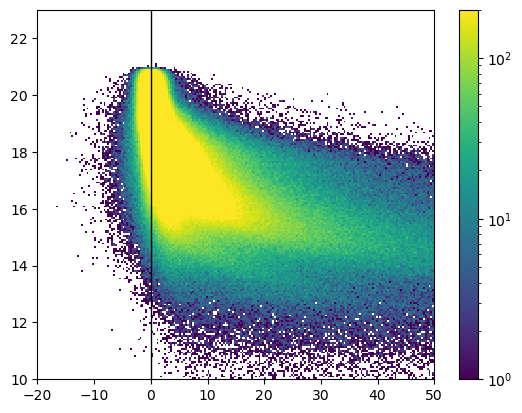

In [157]:
from matplotlib.path import Path
import matplotlib.patches as patches
fig, ax = plt.subplots()

h, parallax_over_error_edges, phot_g_mean_mag_edges, _ =plt.hist2d(data['parallax_over_error'], data['phot_g_mean_mag'], bins=(210,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,200))
plt.colorbar()

ax.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
plt.show()

In [158]:
# What is the bin index in parallax space that contains zero?
# The way we map the mirror bin relies on the left edge of this bin being zero
zero_bin_index = np.digitize(0, parallax_over_error_edges)
print(zero_bin_index)
print(parallax_over_error_edges[zero_bin_index-1], parallax_over_error_edges[zero_bin_index])

# This creates a limiting error fraction. We aren't actually interested in situations where concivably there
# could be a positive parallax with reasonable uncertainty, so we take away all the bins where the parallax value is less than or equal to double the uncertainty 
limit_bin_index = np.digitize(-1, parallax_over_error_edges)
print(limit_bin_index)
print(parallax_over_error_edges[limit_bin_index-1], parallax_over_error_edges[limit_bin_index])

limit_mask = np.less(np.abs(data['parallax_over_error']), 1)

# All our numpy arrays
mirror_poe = []
mirror_mag = []
mirror_ra = []
mirror_dec = []
mirror_pmra = []
mirror_pmdec = []
mirror_pmra_error = []
mirror_pmdec_error = []


phot_g_mean_mag_bin_indicies= np.digitize(data['phot_g_mean_mag'], phot_g_mean_mag_edges)
#_, phot_g_mean_mag_bin_counts = np.unique(phot_g_mean_mag_bin_indicies, return_counts=True)
idxs_mag, counts_mag = np.unique(phot_g_mean_mag_bin_indicies, return_counts=True)

#print(len(phot_g_mean_mag_bin_indicies))
#print(idxs_mag)
#print(counts_mag)

# Go through all rows (which are mag buckets)
for idx_mag in idxs_mag:
    #print(f"working on row {idx_mag}")

    # don't use the zeroth row because it has infinite extent
    if idx_mag == 0:
        continue

    rowmask = np.not_equal(phot_g_mean_mag_bin_indicies, idx_mag)
    
    # There has got to be a better way to do this...
    poe_row = np.ma.masked_array(data['parallax_over_error'], mask=rowmask).compressed()
    mag_row = np.ma.masked_array(data['phot_g_mean_mag'], mask=rowmask).compressed()
    ra_row = np.ma.masked_array(data['ra'], mask=rowmask).compressed()
    dec_row = np.ma.masked_array(data['dec'], mask=rowmask).compressed()
    pmra_row = np.ma.masked_array(data['pmra'], mask=rowmask).compressed()
    pmdec_row = np.ma.masked_array(data['pmdec'], mask=rowmask).compressed()
    pmra_error_row = np.ma.masked_array(data['pmra_error'], mask=rowmask).compressed()
    pmdec_error_row = np.ma.masked_array(data['pmdec_error'], mask=rowmask).compressed()
    

    poe_row_bin_indicies = np.digitize(poe_row, parallax_over_error_edges)
    row_bin_indexs, poe_row_bin_counts =  np.unique(poe_row_bin_indicies, return_counts=True)

    for (idx_poe, point_count) in zip(row_bin_indexs, poe_row_bin_counts):
        #print(f"working on bin {idx_poe}, has {point_count} points")

        # Don't work on the zeroth bin because it has infinite extent and is weird
        if idx_poe == 0:
            continue

        # When we hit the index where the uncertainty story starts to make some sense, we stop
        if idx_poe >= limit_bin_index:
            #print(f"Reached zero bin, done w/ negative stuff")
            break

        # What is the index of the bin reflected across the zero bin
        # Note that the zero bin's left edge is zero
        mirror_bin_idx = 2 * zero_bin_index - idx_poe - 1

        # Mask of the current histogram row such that only the values in the mirror bin are
        # unmasked
        mirror_bin_mask = np.not_equal(poe_row_bin_indicies, mirror_bin_idx)

        # If there aren't any comparables to find in the mirror bin, just ignore it
        # Given the distribution above, this shouldn't happen that often
        if np.count_nonzero(mirror_bin_mask) == len(mirror_bin_mask):
            #print("no comparables in the mirror bin")
            continue

        # Indexes in the histogram row for everything in the mirror bin
        mirror_bin_row_indexes = np.ma.masked_array(np.arange(len(poe_row)), mask=mirror_bin_mask).compressed()

        # Indexes for the mirror data points we are selecting
        selected_row_indexes = np.random.choice(mirror_bin_row_indexes, point_count)

        for selected_row_index in selected_row_indexes:
            mirror_poe.append(poe_row[selected_row_index])
            mirror_mag.append(mag_row[selected_row_index])
            mirror_ra.append(ra_row[selected_row_index])
            mirror_dec.append(dec_row[selected_row_index])
            mirror_pmra.append(pmra_row[selected_row_index])
            mirror_pmdec.append(pmdec_row[selected_row_index])
            mirror_pmra_error.append(pmra_error_row[selected_row_index])
            mirror_pmdec_error.append(pmdec_error_row[selected_row_index])
    
            # Save off the positive bin values into an array for future plotting
            # MAY also need other things like ra, dec, pmra, pmdec that we want to plot
            


#When we're done there should be 2 sets of arrays
# positive parallax_over_error (parallax over error and g_mag) these have been constructed, and we need all variables that I want to plot with
mirror_poe = np.array(mirror_poe)
mirror_mag = np.array(mirror_mag)
mirror_ra = np.array(mirror_ra)
mirror_dec = np.array(mirror_dec)
mirror_pmra = np.array(mirror_pmra)
mirror_pmdec = np.array(mirror_pmdec)
mirror_pmra_error = np.array(mirror_pmra_error)
mirror_pmdec_error = np.array(mirror_pmdec_error)

# negative parallax_over_error (parallax_over error and g_mag) these are just data[blarg] masked
problem_poe = np.ma.masked_array(data['parallax_over_error'], mask = np.logical_or(negative_parallax, limit_mask)).compressed()
problem_mag = np.ma.masked_array(data['phot_g_mean_mag'], mask = np.logical_or(negative_parallax, limit_mask)).compressed() 



61
0.0 0.33333333333333215
58
-1.0 -0.6666666666666679


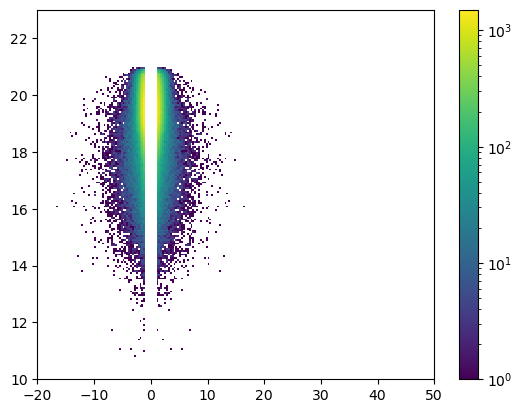

122473 122459 1573.0


In [159]:
h, _, _, _ = plt.hist2d(problem_poe, problem_mag, 
           bins=(210,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,1500))
plt.hist2d(mirror_poe, mirror_mag,
           bins=(210,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,1500))
plt.colorbar()

ax.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
plt.show()

print(
len(np.ma.masked_array(data['parallax_over_error'], mask = np.logical_or(negative_parallax, limit_mask)).compressed()),
len(mirror_poe),
np.max(h)
)

In [160]:
from astropy.coordinates import SkyCoord, BarycentricMeanEcliptic
import astropy.units as u

#Should not be using anymore before the fold
#coords = SkyCoord(data['ra'], data['dec'], pm_ra_cosdec=data['pmra'], pm_dec=data['pmdec'])
#ellipticCoords = coords.transform_to(BarycentricMeanEcliptic)

mirror_coords = SkyCoord(mirror_ra*u.deg, mirror_dec*u.deg, pm_ra_cosdec = mirror_pmra*u.mas/u.yr, pm_dec = mirror_pmdec*u.mas/u.yr)
mirror_ecoords = mirror_coords.transform_to(BarycentricMeanEcliptic)

problem_coords = SkyCoord(np.ma.masked_array(data['ra'], mask= np.logical_or(negative_parallax, limit_mask)).compressed(), 
                          np.ma.masked_array(data['dec'], mask= np.logical_or(negative_parallax, limit_mask)).compressed(), 
                          pm_ra_cosdec = np.ma.masked_array(data['pmra'], mask= np.logical_or(negative_parallax, limit_mask)).compressed(), 
                          pm_dec = np.ma.masked_array(data['pmdec'], mask= np.logical_or(negative_parallax, limit_mask)).compressed())
problem_ecoords = problem_coords.transform_to(BarycentricMeanEcliptic)

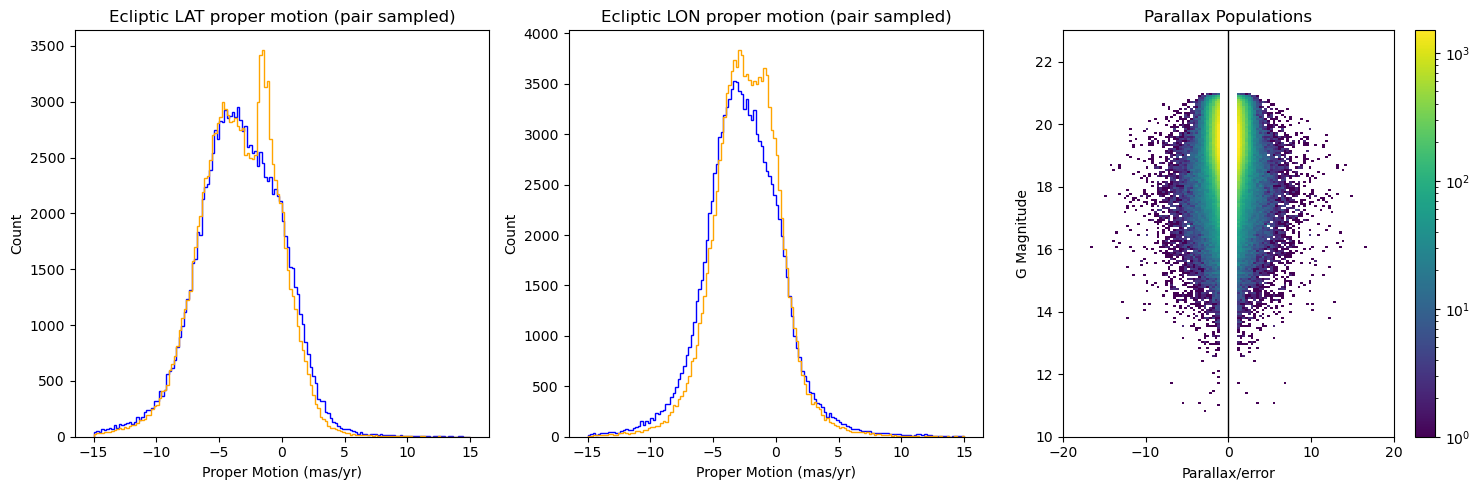

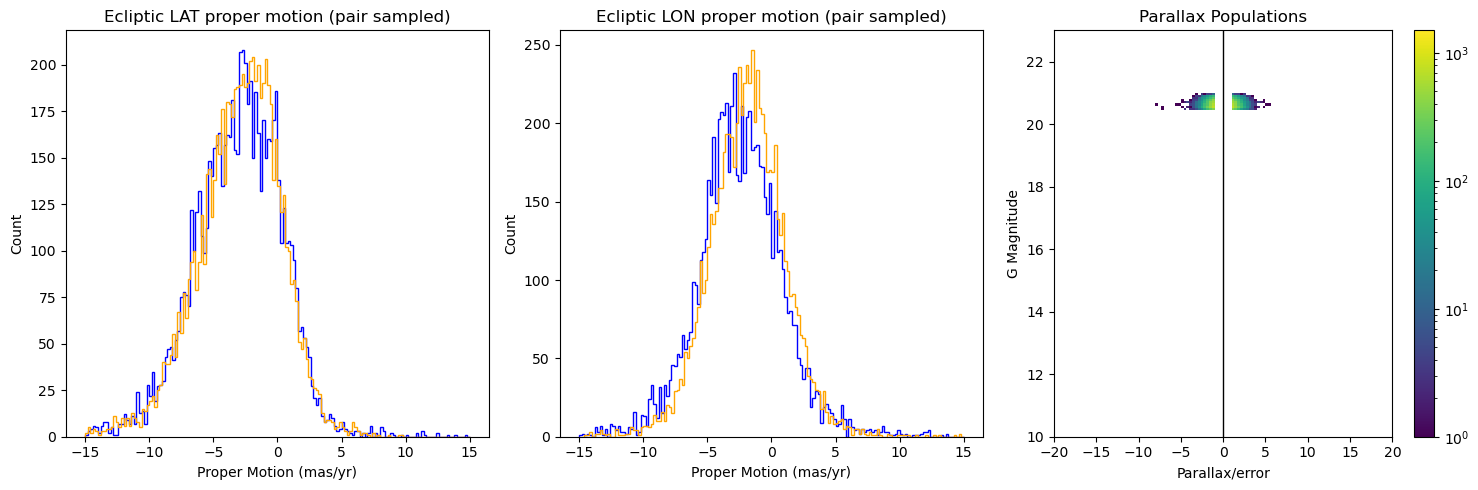

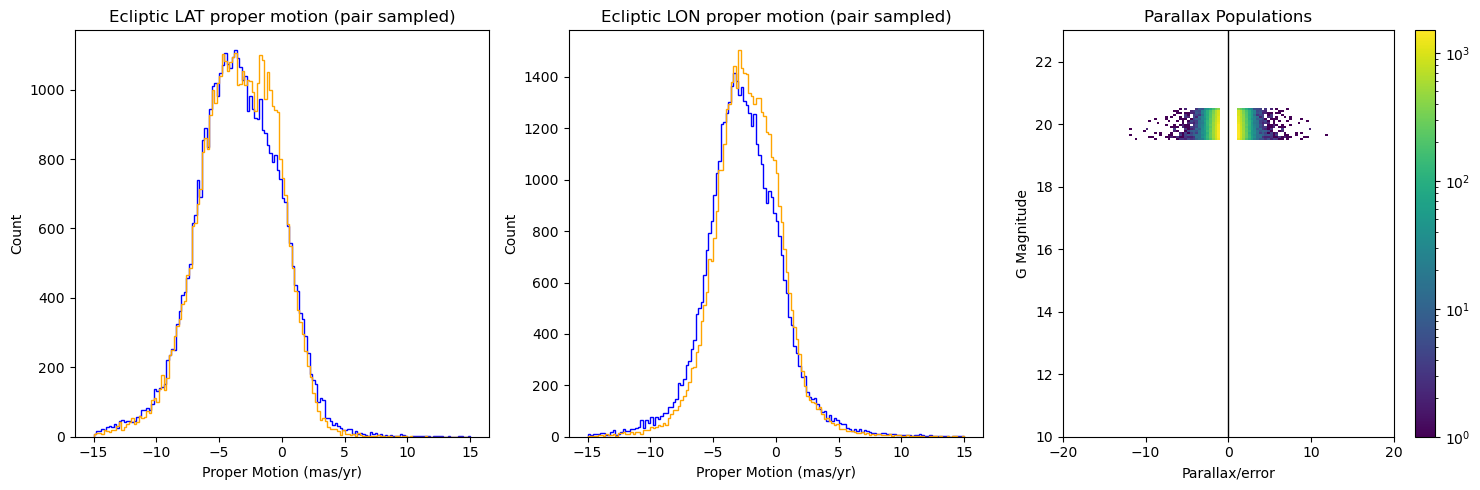

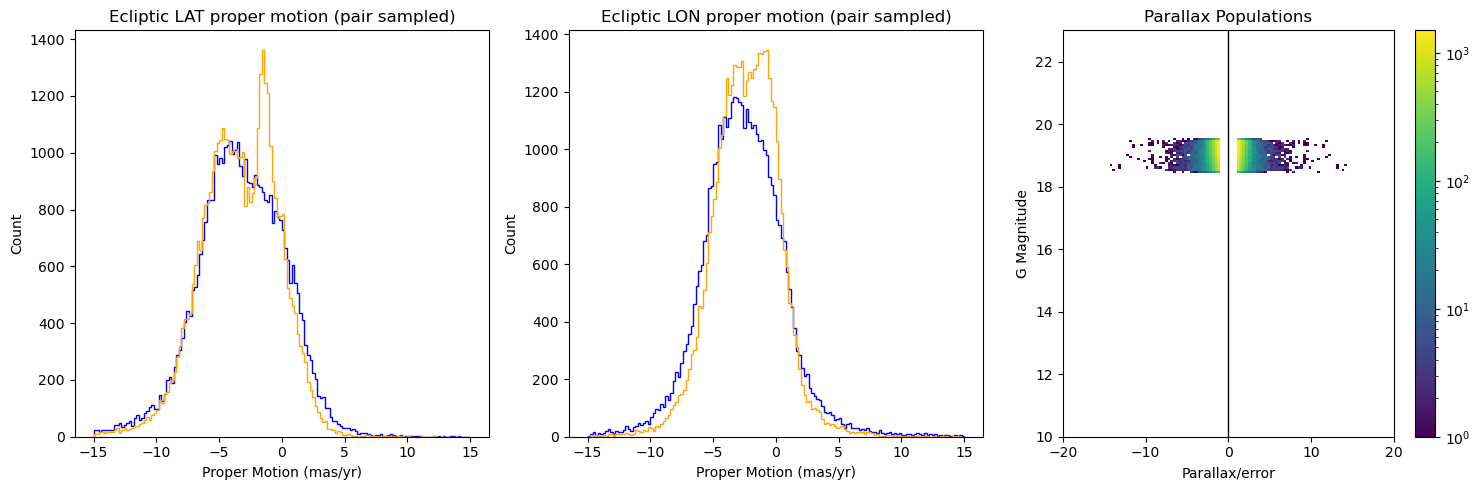

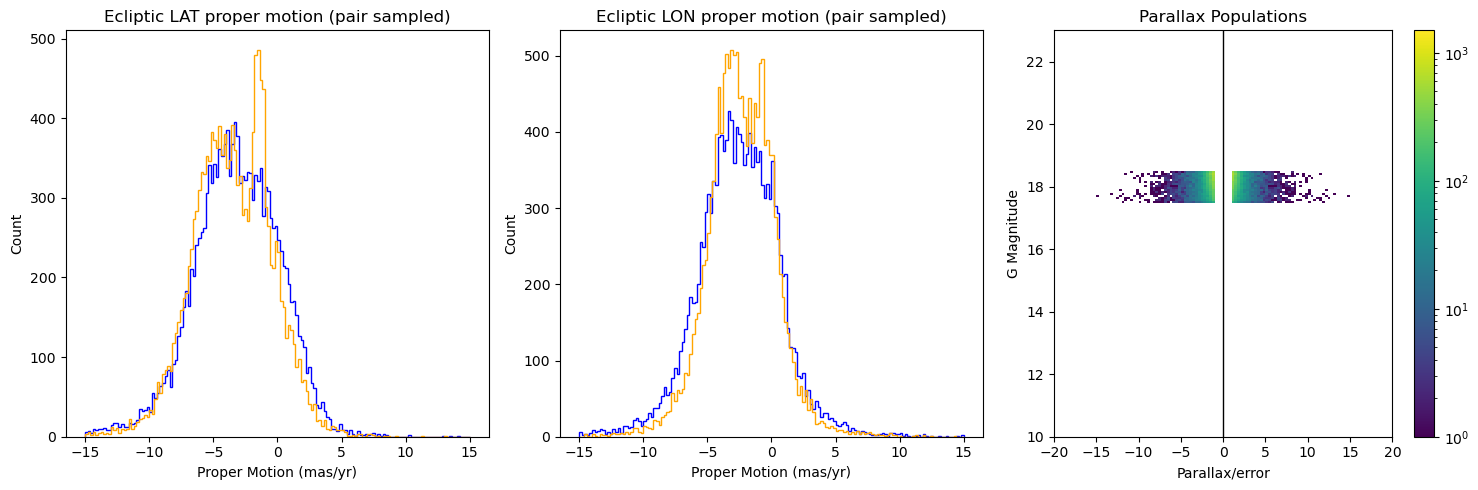

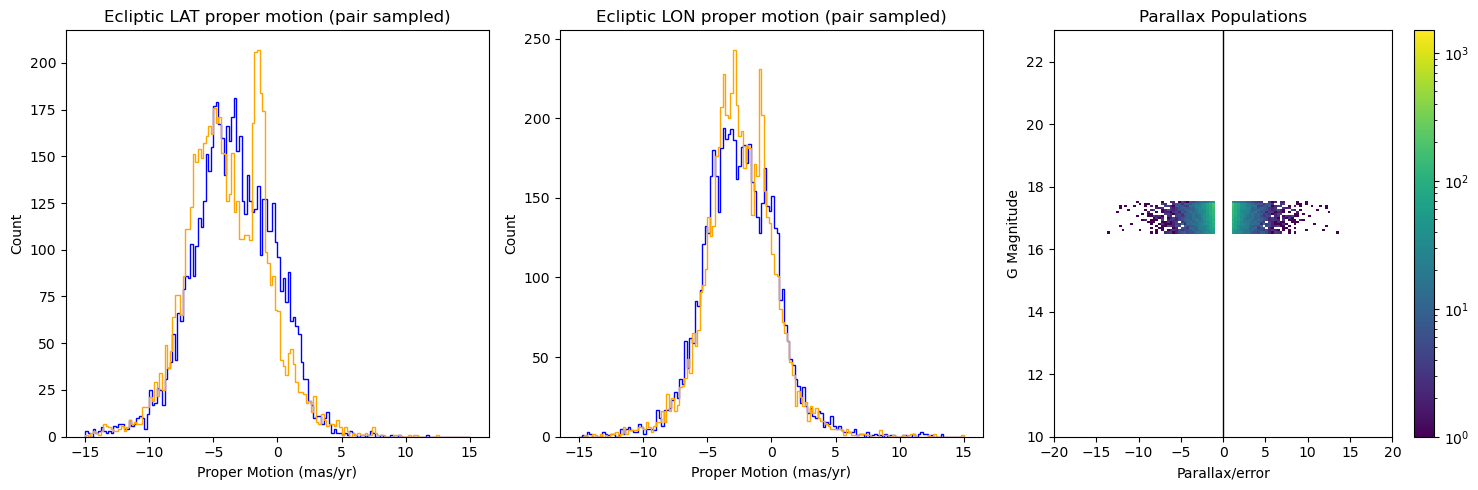

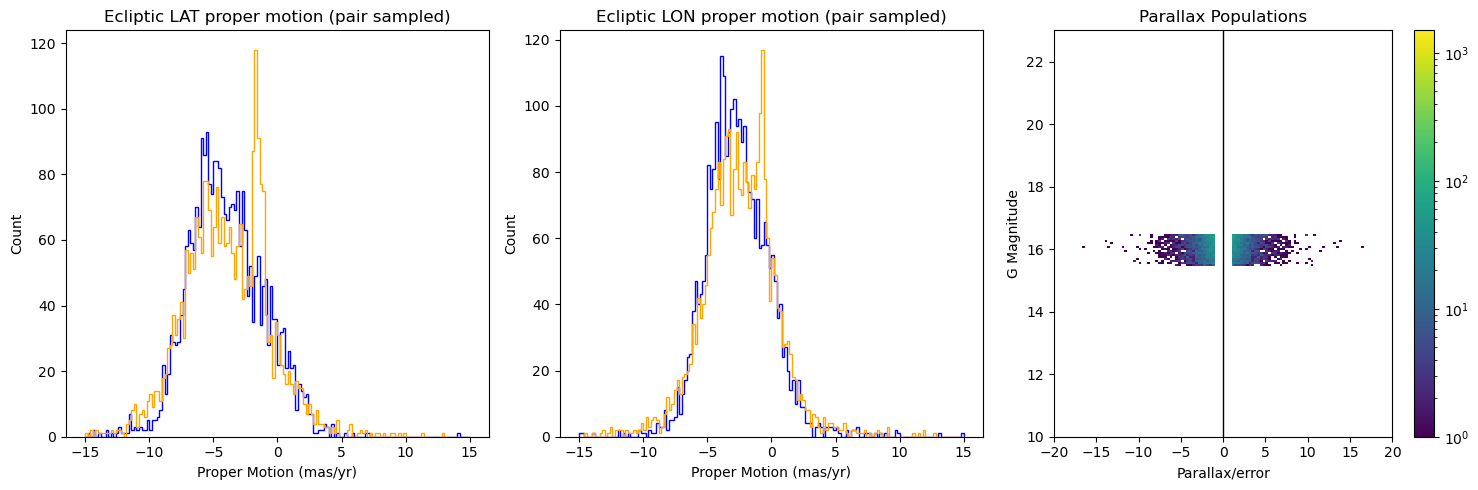

In [161]:



# Make plots of LAT/LON showing mirror(positive parallax) and problem (negative parallax) histograms
# Allow pass in of a mask so we can go by mag.
def visualize_ecliptic_proper_motion(mirror_ecoords, problem_ecoords, mirror_poe, mirror_mag, problem_poe, problem_mag,
                                     mirror_mask = None, problem_mask = None):

    fig,(ax1, ax2, ax3) = plt.subplots(nrows=1, ncols = 3)

    fig.set_size_inches(15, 5)

    ax1.set_title("Ecliptic LAT proper motion (pair sampled)")
    ax1.set_xlabel("Proper Motion (mas/yr)")
    ax1.set_ylabel("Count")

    ax1.hist(np.ma.masked_array(mirror_ecoords.pm_lat.value, mask = mirror_mask).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="blue")
    ax1.hist(np.ma.masked_array(problem_ecoords.pm_lat.value, mask = problem_mask).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="orange")
    
    ax2.set_title("Ecliptic LON proper motion (pair sampled)")
    ax2.set_xlabel("Proper Motion (mas/yr)")
    ax2.set_ylabel("Count")

    ax2.hist(np.ma.masked_array(mirror_ecoords.pm_lon_coslat.value, mask = mirror_mask).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="blue")
    ax2.hist(np.ma.masked_array(problem_ecoords.pm_lon_coslat.value, mask = problem_mask).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="orange")
    
    ax3.set_title("Parallax Populations")
    ax3.set_xlabel("Parallax/error")
    ax3.set_ylabel("G Magnitude")
    _,_,_,im = ax3.hist2d(
        np.ma.masked_array(problem_poe, mask = problem_mask).compressed(), 
        np.ma.masked_array(problem_mag, mask = problem_mask).compressed(), 
        bins=(120,200), range=((-20,20), (10,23)) , norm=colors.LogNorm(1,1500))
    ax3.hist2d(
        np.ma.masked_array(mirror_poe, mask = mirror_mask).compressed(),
        np.ma.masked_array(mirror_mag, mask = mirror_mask).compressed(),
        bins=(120,200), range=((-20,20), (10,23)) , norm=colors.LogNorm(1,1500))
    plt.colorbar(im)

    ax3.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
    
    plt.tight_layout()
    plt.show()

visualize_ecliptic_proper_motion(mirror_ecoords, problem_ecoords, mirror_poe, mirror_mag, problem_poe, problem_mag)

mirror_mask_bin_indexes = np.digitize(mirror_mag, np.linspace(21.5,10.5,12))
problem_mask_bin_indexes = np.digitize(problem_mag, np.linspace(21.5,10.5,12))
for bin_index in range(1,7):
    mirror_mask = np.not_equal(bin_index, mirror_mask_bin_indexes)
    problem_mask = np.not_equal(bin_index, problem_mask_bin_indexes)
    visualize_ecliptic_proper_motion(mirror_ecoords, problem_ecoords, mirror_poe, mirror_mag, problem_poe, problem_mag, 
                                     mirror_mask=mirror_mask, problem_mask=problem_mask)

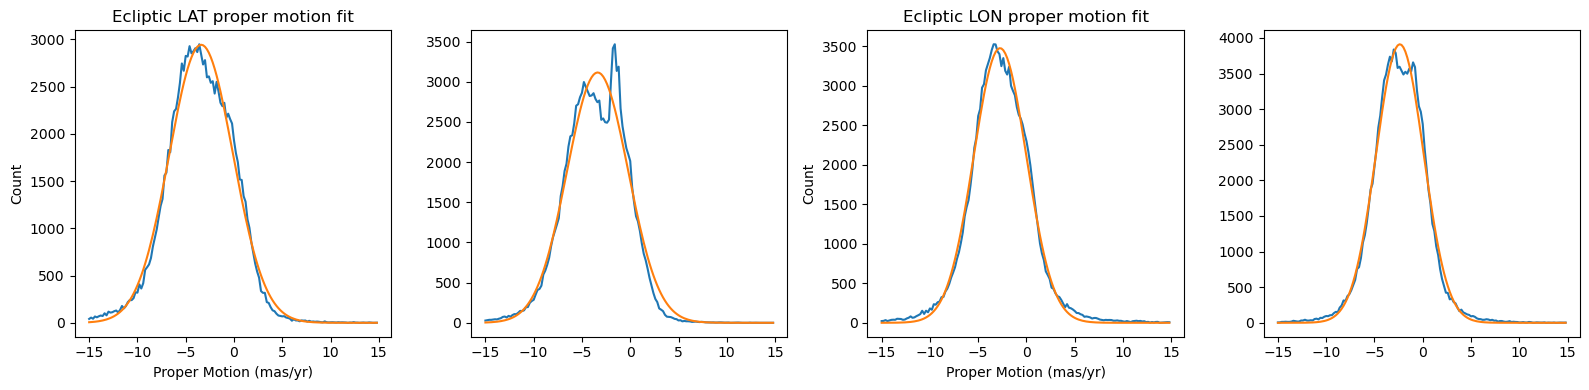

(0.023468204251486213, 0.3672195347994016)


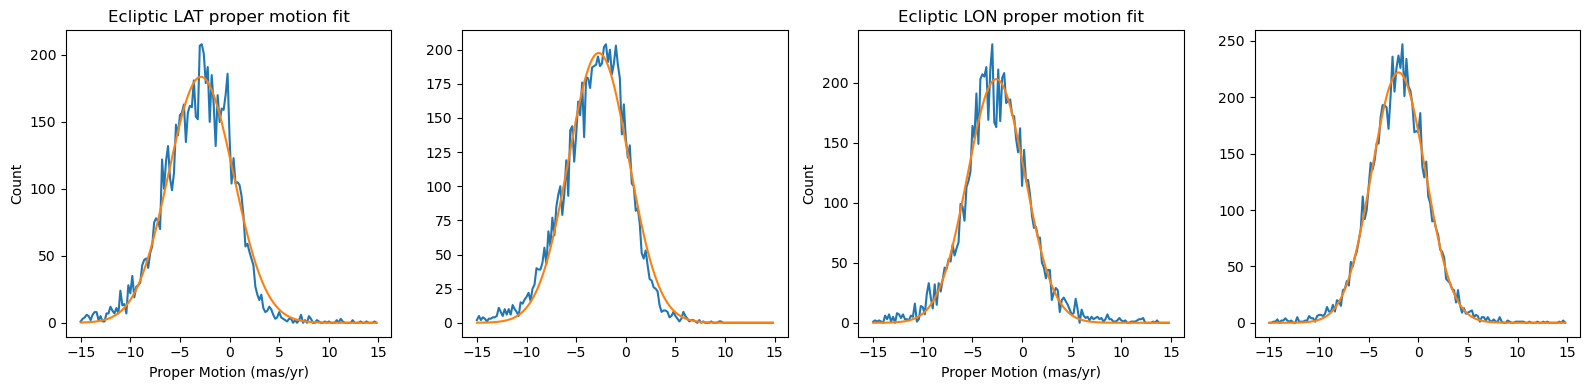

(0.15318584940572233, 0.6193666779838789)


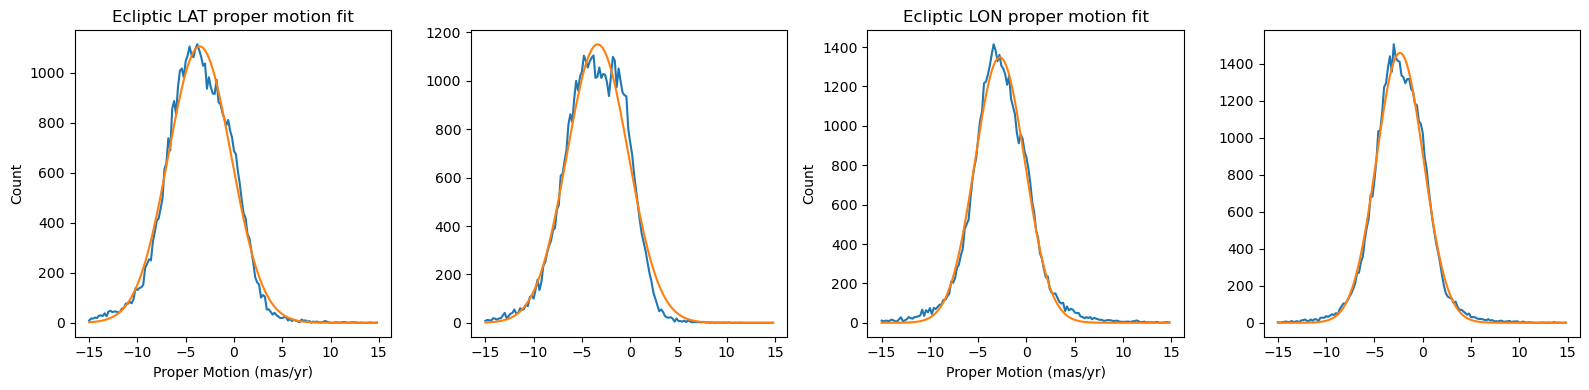

(0.17293272456055764, 0.39444116198344625)


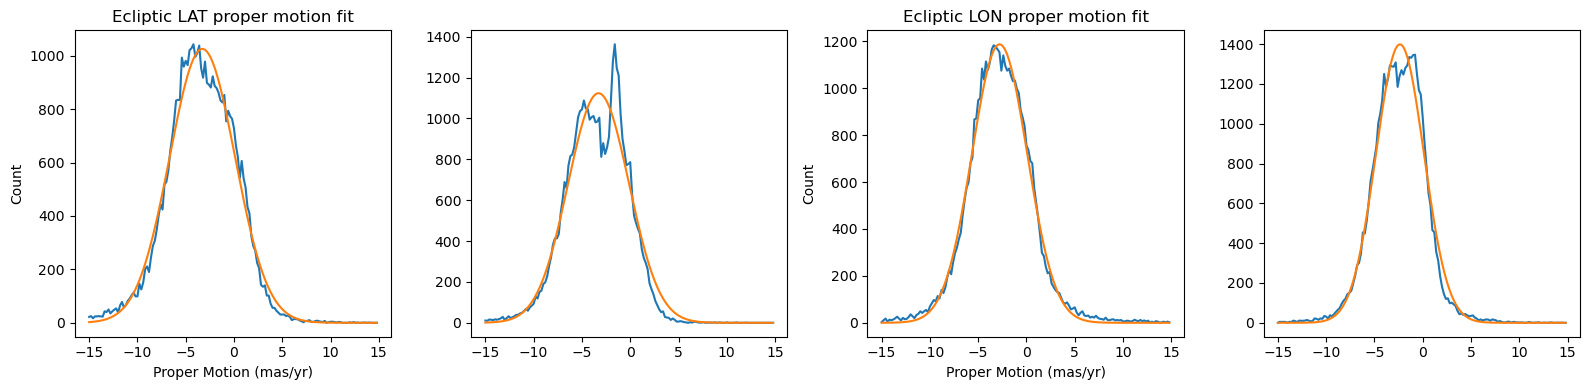

(-0.004036182344300254, 0.4259850320335308)


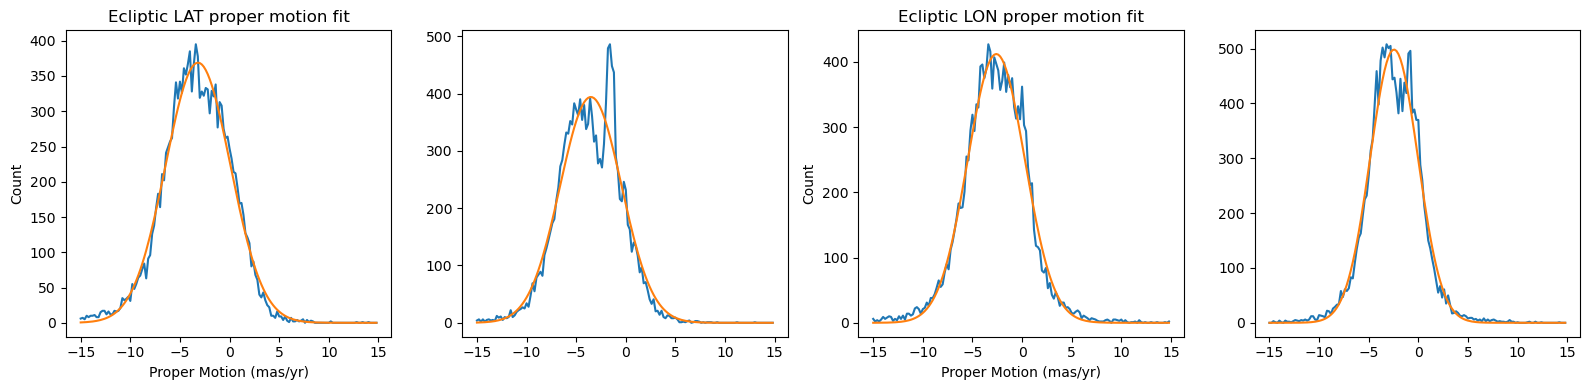

(-0.34301508268302694, 0.15182265119735439)


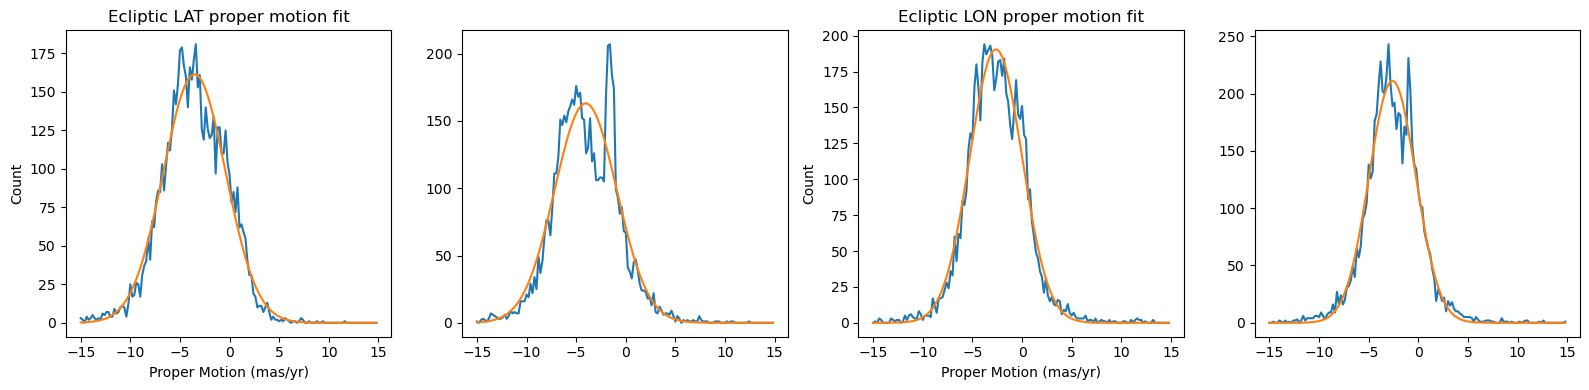

(-0.5044941400997285, 0.029180250136726205)


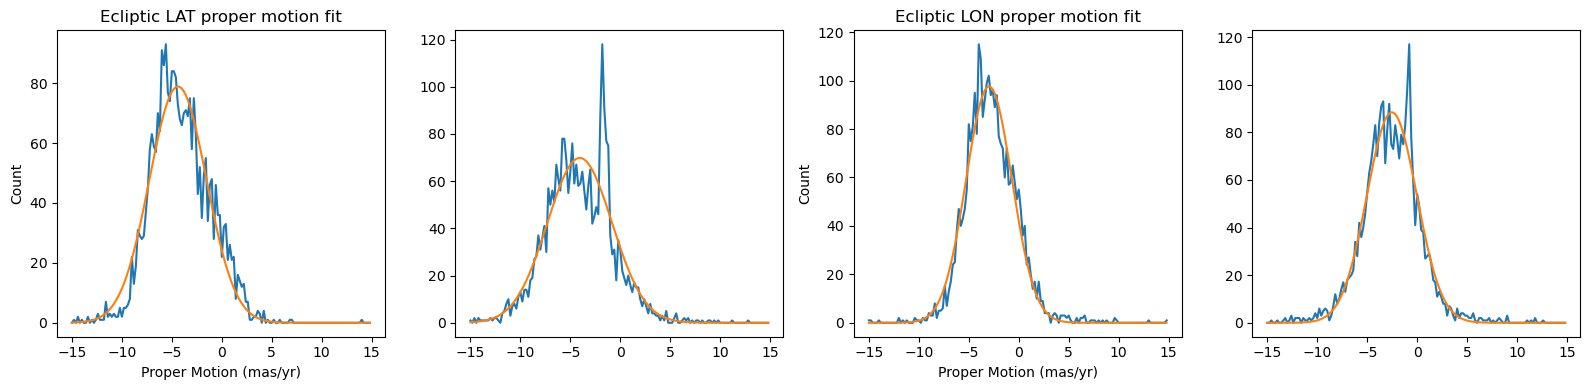

(0.32729669594520505, 0.4388161844825964)


In [162]:
from astropy.modeling import fitting, models
# Next up curve fit these and arrive at offsets for lat and lon across mags
# should return a tuple of the lat, lon biases
def ecliptic_proper_motion_bias(mirror_ecoords, problem_ecoords, mirror_mask = None, problem_mask = None):

    mirror_pm_lat = np.ma.masked_array(mirror_ecoords.pm_lat.value, mask = mirror_mask).compressed()
    mirror_pm_lon = np.ma.masked_array(mirror_ecoords.pm_lon_coslat.value, mask = mirror_mask).compressed()
    problem_pm_lat = np.ma.masked_array(problem_ecoords.pm_lat.value, mask = problem_mask).compressed()
    problem_pm_lon = np.ma.masked_array(problem_ecoords.pm_lon_coslat.value, mask = problem_mask).compressed()


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)

    fig.set_size_inches(16,4)

    ax1.set_title("Ecliptic LAT proper motion fit")
    ax1.set_xlabel("Proper Motion (mas/yr)")
    ax1.set_ylabel("Count")
    mirror_lat_fit = fit_ecliptic_proper_motion(mirror_pm_lat, ax=ax1)
    problem_lat_fit = fit_ecliptic_proper_motion(problem_pm_lat, ax=ax2)

    lat_bias = problem_lat_fit.parameters[1] - mirror_lat_fit.parameters[1]

    ax3.set_title("Ecliptic LON proper motion fit")
    ax3.set_xlabel("Proper Motion (mas/yr)")
    ax3.set_ylabel("Count")
    mirror_lon_fit = fit_ecliptic_proper_motion(mirror_pm_lon, ax=ax3)
    problem_lon_fit = fit_ecliptic_proper_motion(problem_pm_lon, ax=ax4)

    lon_bias = problem_lon_fit.parameters[1] - mirror_lon_fit.parameters[1]

    plt.tight_layout()
    plt.show()

    return (lat_bias, lon_bias)

# Hands back a fitted gaussian model for a single set of proper motions
# And a set of bins?
def fit_ecliptic_proper_motion(pm, ax=None):

    fit = fitting.LevMarLSQFitter()
    hist, bins = np.histogram(pm, bins = 150, range=(-15,15))
    model = models.Gaussian1D(1300, -2, 5)
    fitted_gaussian = fit(model, bins[:-1], hist, maxiter=1000)

    if ax != None:
        ax.plot(bins[:-1], hist)
        ax.plot(bins[:-1], fitted_gaussian(bins[:-1]))

    return fitted_gaussian

a = ecliptic_proper_motion_bias(mirror_ecoords, problem_ecoords)
print(a)

for bin_index in range(1,7):
    mirror_mask = np.not_equal(bin_index, mirror_mask_bin_indexes)
    problem_mask = np.not_equal(bin_index, problem_mask_bin_indexes)
    a = ecliptic_proper_motion_bias(mirror_ecoords, problem_ecoords, mirror_mask=mirror_mask, problem_mask=problem_mask)
    print(a)

In [ ]:
# Also todo, plot the pmra/pmdec errors for each population

In [ ]:
# Plot both of these together so we can see how much lat/lon systemic error matters by mag bucket

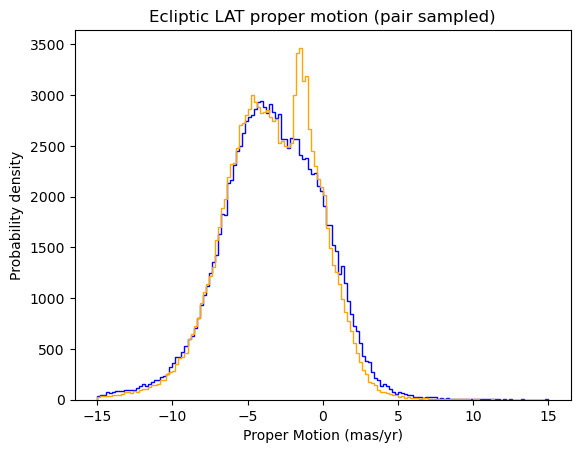

In [106]:
plt.title("Ecliptic LAT proper motion (pair sampled)")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(mirror_ecoords.pm_lat.value, 
         bins = 150, range=(-15,15), histtype='step', color="blue")
plt.hist(np.ma.masked_array(ellipticCoords.pm_lat.value, mask = np.logical_or(negative_parallax, limit_mask)).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="orange")

plt.show()

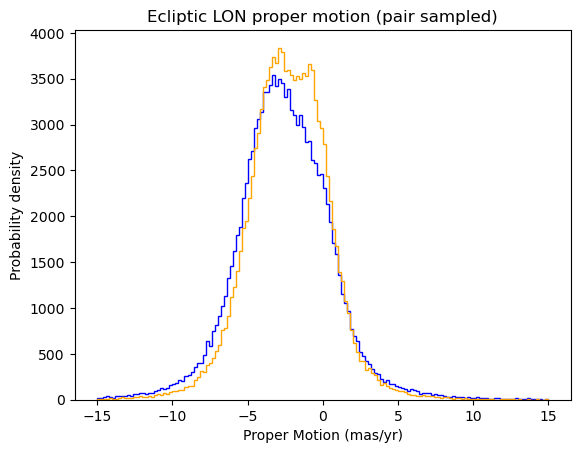

In [61]:
plt.title("Ecliptic LON proper motion (pair sampled)")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(mirror_ecoords.pm_lon_coslat.value, 
         bins = 150, range=(-15,15), histtype='step', color="blue")
plt.hist(np.ma.masked_array(ellipticCoords.pm_lon_coslat.value, mask = np.logical_or(negative_parallax, limit_mask)).compressed(), 
         bins = 150, range=(-15,15), histtype='step', color="orange")

plt.show()

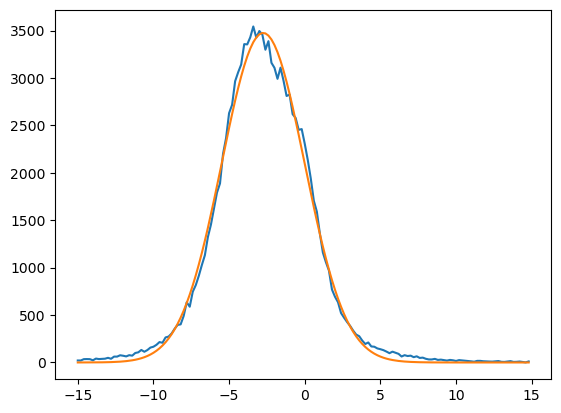

[ 3.47507261e+03 -2.74742202e+00  2.73031675e+00]


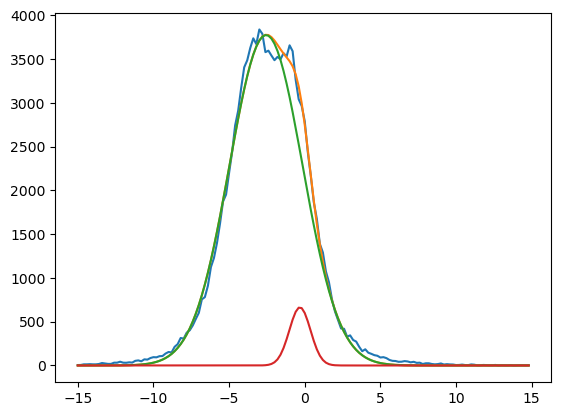

[ 3.77465760e+03 -2.55722994e+00  2.41070160e+00  6.64764503e+02
 -3.17402951e-01  6.98163798e-01]
LON proper motion imparted by negative parallax = 0.19019208342837768


In [73]:
from astropy.modeling import fitting, models

fit = fitting.LevMarLSQFitter()

hist, bins = np.histogram(mirror_ecoords.pm_lon_coslat.value, bins = 150, range=(-15,15))
model = models.Gaussian1D(1300, -2, 5)
mirror_gaussian = fit(model, bins[:-1], hist, maxiter=1000)

plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], mirror_gaussian(bins[:-1]))
plt.show()

print(mirror_gaussian.parameters)

fit = fitting.LevMarLSQFitter()

hist, bins = np.histogram(np.ma.masked_array(ellipticCoords.pm_lon_coslat.value, mask = np.logical_or(negative_parallax, limit_mask)).compressed(), bins = 150, range=(-15,15))

model = models.Gaussian1D(1300, -2, 7) + models.Gaussian1D(3500, 0, 0.1)
fitted_gaussian = fit(model, bins[:-1], hist, maxiter=1000)

plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian[0](bins[:-1]))
plt.plot(bins[:-1], fitted_gaussian[1](bins[:-1]))
plt.show()

print(fitted_gaussian.parameters)

print(f"LON proper motion imparted by negative parallax = {fitted_gaussian.parameters[1] - mirror_gaussian.parameters[1]}")



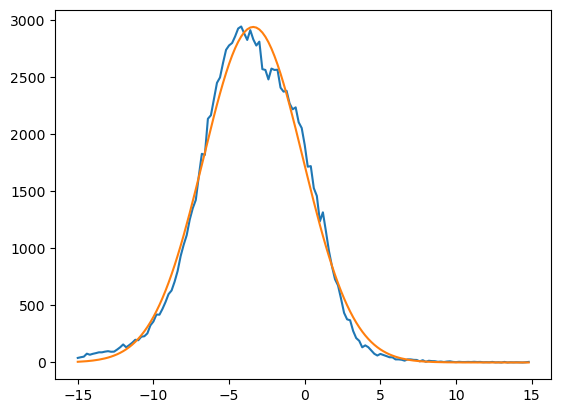

[2941.00819437   -3.40589097    3.29973094]


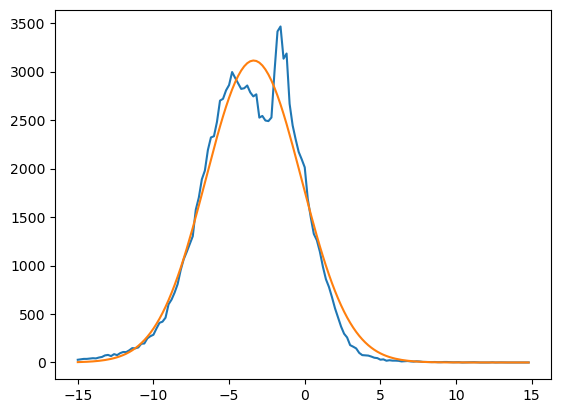

[3115.01386503   -3.37609383    3.16639268]
LAT proper motion imparted by negative parallax = 0.02979713522088545


In [75]:
from astropy.modeling import fitting, models

fit = fitting.LevMarLSQFitter()

hist, bins = np.histogram(mirror_ecoords.pm_lat.value, bins = 150, range=(-15,15))
model = models.Gaussian1D(1300, -2, 5)
mirror_gaussian = fit(model, bins[:-1], hist, maxiter=1000)

plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], mirror_gaussian(bins[:-1]))
plt.show()

print(mirror_gaussian.parameters)

fit = fitting.LevMarLSQFitter()

hist, bins = np.histogram(np.ma.masked_array(ellipticCoords.pm_lat.value, mask = np.logical_or(negative_parallax, limit_mask)).compressed(), bins = 150, range=(-15,15))

model = models.Gaussian1D(1300, -2, 7)# + models.Gaussian1D(3500, 0, 0.1)
fitted_gaussian = fit(model, bins[:-1], hist, maxiter=1000)

plt.plot(bins[:-1], hist)
plt.plot(bins[:-1], fitted_gaussian(bins[:-1]))
#plt.plot(bins[:-1], fitted_gaussian[0](bins[:-1]))
#plt.plot(bins[:-1], fitted_gaussian[1](bins[:-1]))
plt.show()

print(fitted_gaussian.parameters)

print(f"LAT proper motion imparted by negative parallax = {fitted_gaussian.parameters[1] - mirror_gaussian.parameters[1]}")

----------------

437928
2794543


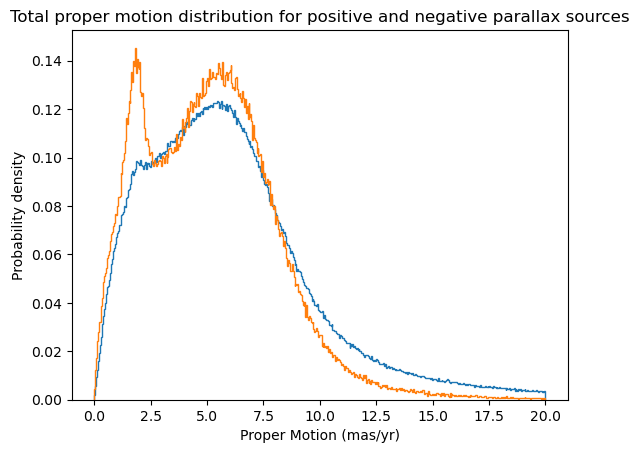

In [ ]:
# proper motion for positive parallax

positive_parallax = np.less(data['parallax'], 0)
negative_parallax = np.logical_not(positive_parallax)

print(np.count_nonzero(positive_parallax))
print(np.count_nonzero(negative_parallax))

plt.title("Total proper motion distribution for positive and negative parallax sources")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pm'], mask = positive_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pm'], mask = negative_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.show()

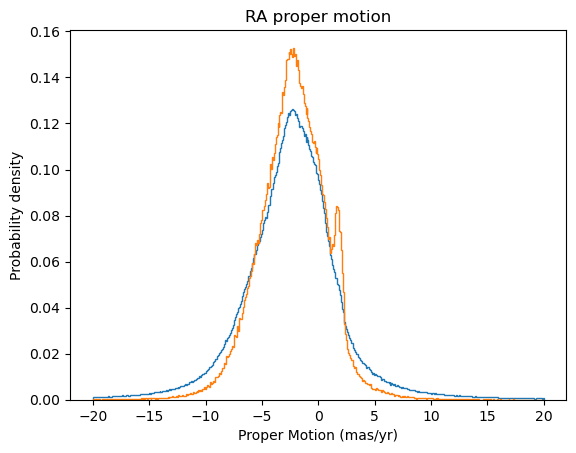

In [ ]:
plt.title("RA proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmra'], mask = positive_parallax).compressed(), bins = 500, range=(-20,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pmra'], mask = negative_parallax).compressed(), bins = 500, range=(-20,20), density=True, histtype='step')
plt.show()

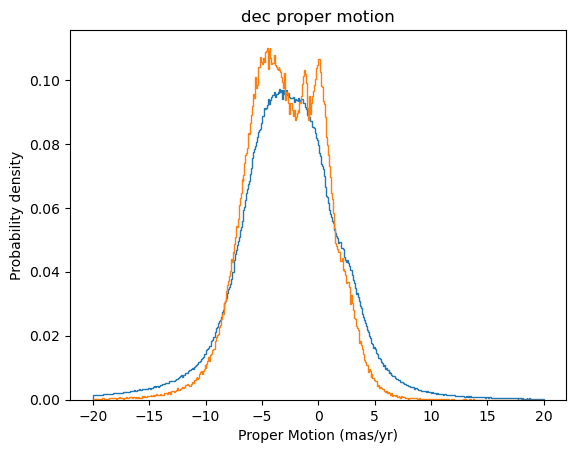

In [ ]:
plt.title("dec proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmdec'], mask = positive_parallax).compressed(), bins = 500, range=(-20,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pmdec'], mask = negative_parallax).compressed(), bins = 500, range=(-20,20), density=True, histtype='step')
plt.show()

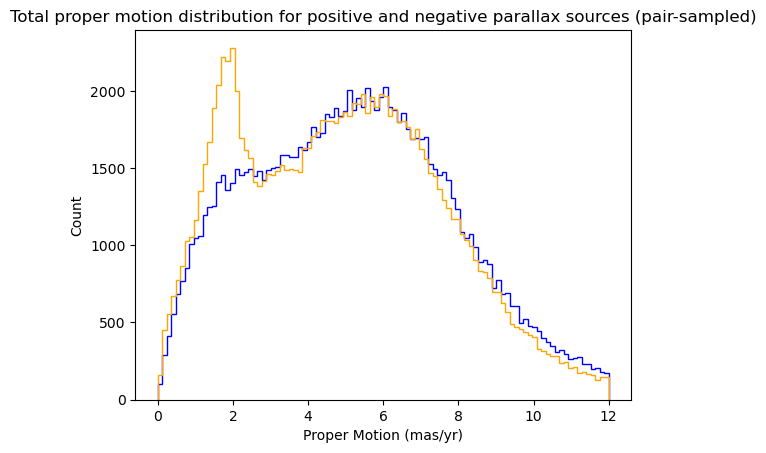

In [ ]:
plt.title("Total proper motion distribution for positive and negative parallax sources (pair-sampled)")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Count")
plt.hist(mirror_pm, bins = 100, range=(0,12), histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pm'], mask = np.logical_or(negative_parallax, limit_mask)).compressed(), bins = 100, range=(0,12), histtype='step', color="orange")
plt.show()


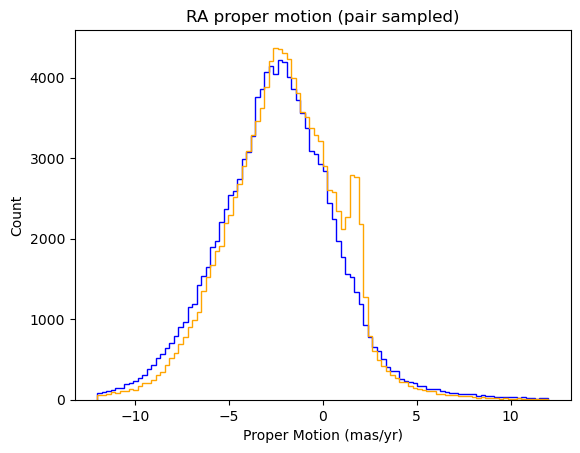

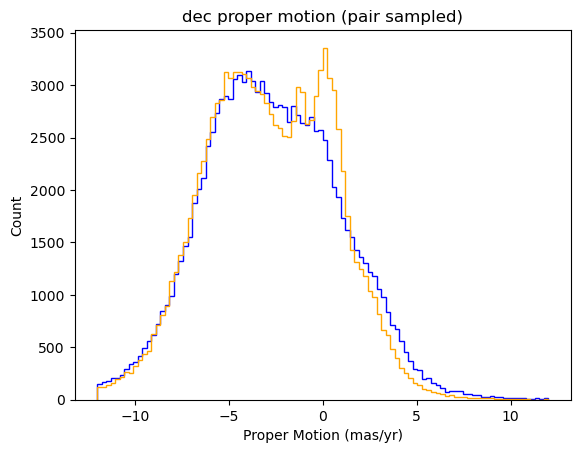

In [ ]:
plt.title("RA proper motion (pair sampled)")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Count")

plt.hist(mirror_pmra, bins = 100, range=(-12,12), histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmra'], mask = np.logical_or(negative_parallax, limit_mask)).compressed(), bins = 100, range=(-12,12), histtype='step', color="orange")

plt.show()

plt.title("dec proper motion (pair sampled)")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Count")

plt.hist(mirror_pmdec, bins = 100, range=(-12,12), histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmdec'], mask = np.logical_or(negative_parallax, limit_mask)).compressed(), bins = 100, range=(-12,12), histtype='step', color="orange")

plt.show()

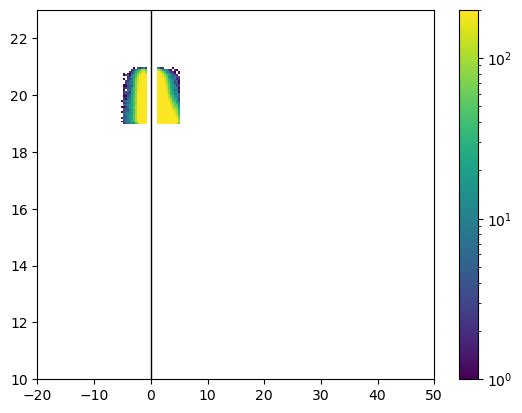

In [63]:
dim_mask = np.less(data['phot_g_mean_mag'], 19)
uncertain_mask = np.greater(np.abs(data['parallax_over_error']), 5)
certain_mask = np.less(np.abs(data['parallax_over_error']), 1)

dim_and_uncertain_mask = np.logical_or(dim_mask, uncertain_mask)
dim_and_certain_mask = np.logical_or(dim_and_uncertain_mask, certain_mask)

fig, ax = plt.subplots()

plt.hist2d(np.ma.masked_array(data['parallax_over_error'], mask=dim_and_certain_mask).compressed(), 
           np.ma.masked_array(data['phot_g_mean_mag'], mask=dim_and_certain_mask).compressed(), 
           bins=(200,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,200))
plt.colorbar()

ax.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
plt.show()

# Could improve this by selecting for each negative parallax, a represenative positive parallax instad of arbitrarily gating, that would at least get me similar brightness
# Could look in 3 d space of (parallax_over_error, abs(parallax), g_mag) or 2 d (parallax_over_error, g_mag)


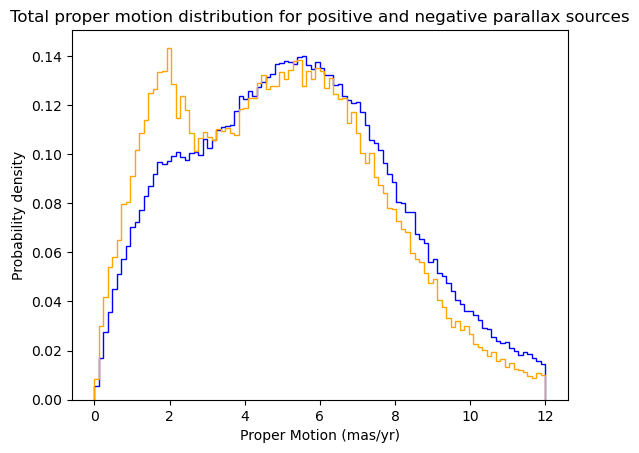

In [64]:
plt.title("Total proper motion distribution for positive and negative parallax sources")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pm'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pm'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="orange")
plt.show()

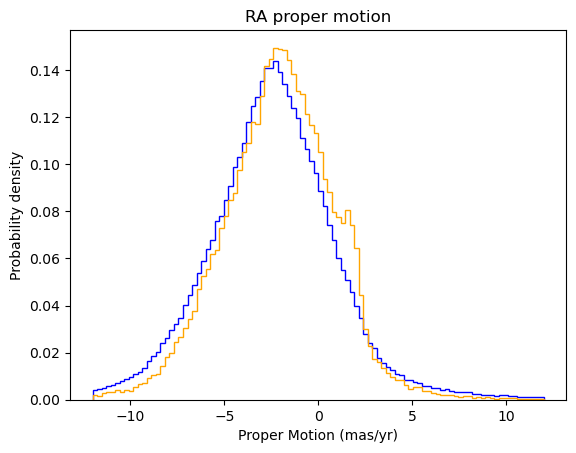

In [65]:
plt.title("RA proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmra'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(-12,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmra'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(-12,12), density=True, histtype='step', color="orange")

plt.show()

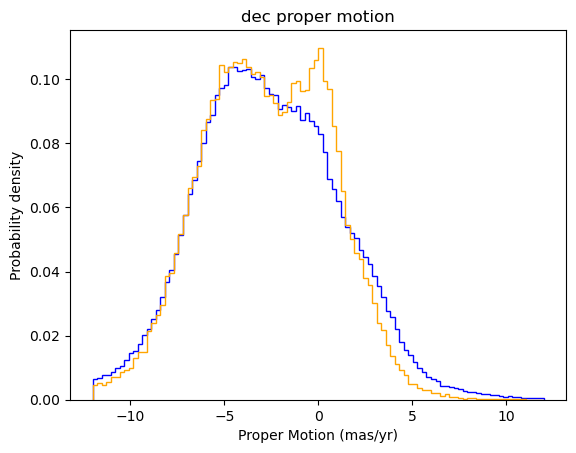

In [66]:
plt.title("dec proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmdec'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(-12,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmdec'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(-12,12), density=True, histtype='step', color="orange")
plt.show()

In [67]:
from astropy.coordinates import SkyCoord, BarycentricMeanEcliptic
import astropy.units as u

coords = SkyCoord(data['ra'], data['dec'], pm_ra_cosdec=data['pmra'], pm_dec=data['pmdec'])

ellipticCoords = coords.transform_to(BarycentricMeanEcliptic)

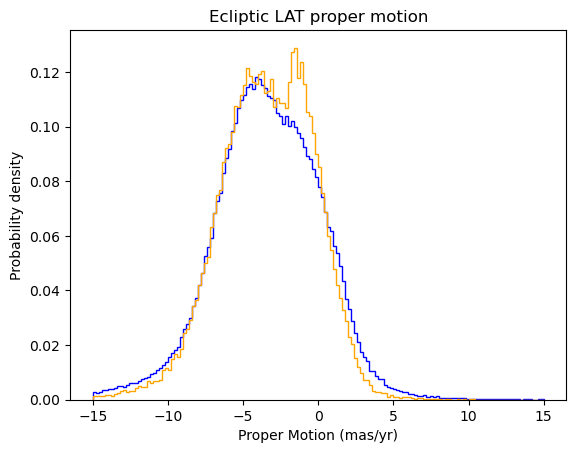

In [68]:
plt.title("Ecliptic LAT proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")



plt.hist(np.ma.masked_array(ellipticCoords.pm_lat.value, mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 150, range=(-15,15), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(ellipticCoords.pm_lat.value, mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 150, range=(-15,15), density=True, histtype='step', color="orange")

plt.show()

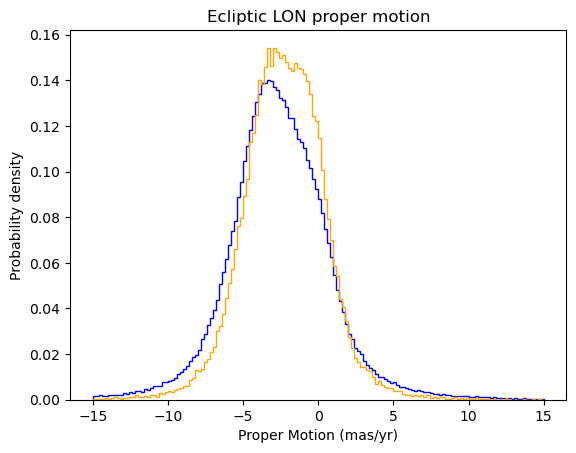

In [69]:
plt.title("Ecliptic LON proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")



plt.hist(np.ma.masked_array(ellipticCoords.pm_lon_coslat.value, mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 150, range=(-15,15), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(ellipticCoords.pm_lon_coslat.value, mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 150, range=(-15,15), density=True, histtype='step', color="orange")

plt.show()

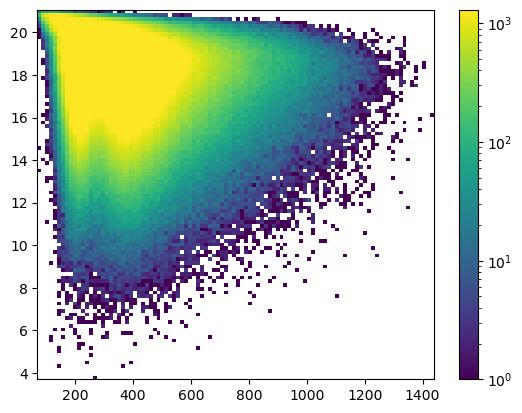

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

plt.hist2d(data['astrometric_n_obs_al'], data['phot_g_mean_mag'], bins=(100,100), norm=colors.LogNorm(1,1300))
plt.colorbar()
plt.show()

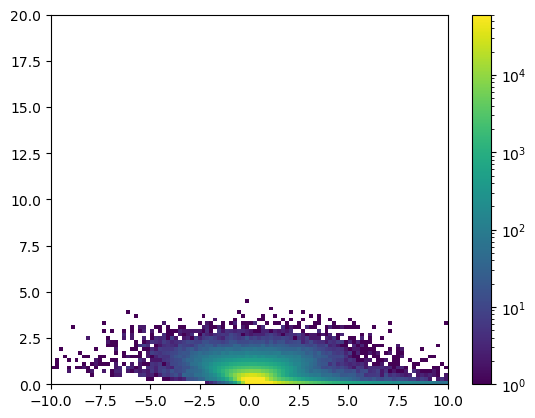

In [ ]:
plt.hist2d(data['parallax'], data['parallax_error'], bins=(100,100), range=((-10,10), (0,20)), norm=colors.LogNorm(1,60000))
plt.colorbar()
plt.show()

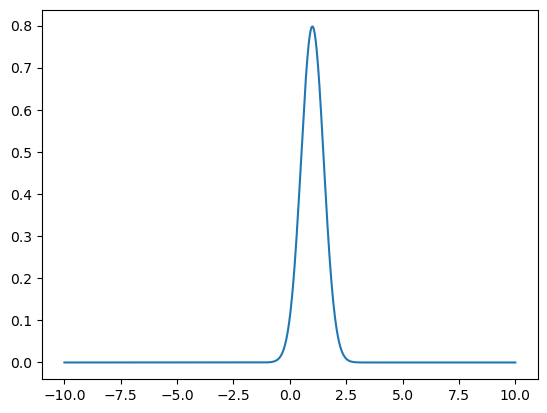

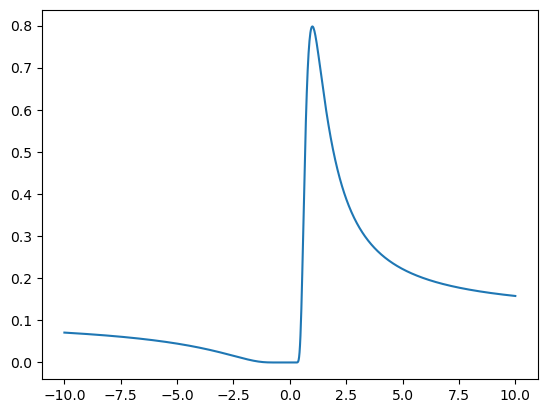

In [ ]:
x = np.linspace(-10,10,1000)
sigma = 0.5 # 1mas of error
mean = 1 #1 kpc

gaussian = ((sigma*np.sqrt(2*np.pi))**-1) * np.exp(-((x-mean)/sigma)**2/2)

plt.plot(x, gaussian)
plt.show()

gaussian_dist = ((sigma*np.sqrt(2*np.pi))**-1) * np.exp(-(((1/x)-mean)/sigma)**2/2)

plt.plot(x, gaussian_dist)
plt.show()




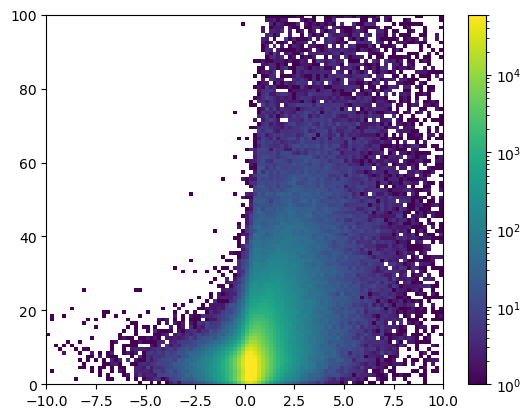

In [ ]:
plt.hist2d(data['parallax'], data['pm'], bins=(100,100), range=((-10,10), (0,100)), norm=colors.LogNorm(1,60000))
plt.colorbar()
plt.show()